In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# # generate some training data
n_samples = 220
seq_len = 18

## generate sin wave data with different frequencies
def generate_sin_wave_data(n_samples, seq_len, noise=0.1, seed=42):
    np.random.seed(seed)
    X = []
    y = []
    for i in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)  # frequency between 0.1 and 1.0
        x = np.linspace(0, 6 * np.pi, seq_len)
        seq = np.sin(freq * x) + np.random.normal(0, noise, seq_len)  # add some noise
        X.append(seq)
        y.append(freq)  # target is the frequency
    X = np.array(X).reshape(n_samples, seq_len, 1)  # shape (n_samples, seq_len, 1)
    y = np.array(y).reshape(n_samples, 1)  # shape (n_samples, 1)
    return X, y

X, y_true = generate_sin_wave_data(n_samples, seq_len, noise=0.05)
# normalize X to [0, 1]
X = (X - X.min()) / (X.max() - X.min())
print(f"Generated data shapes: {X.shape}, {y_true.shape}")

Generated data shapes: (220, 18, 1), (220, 1)


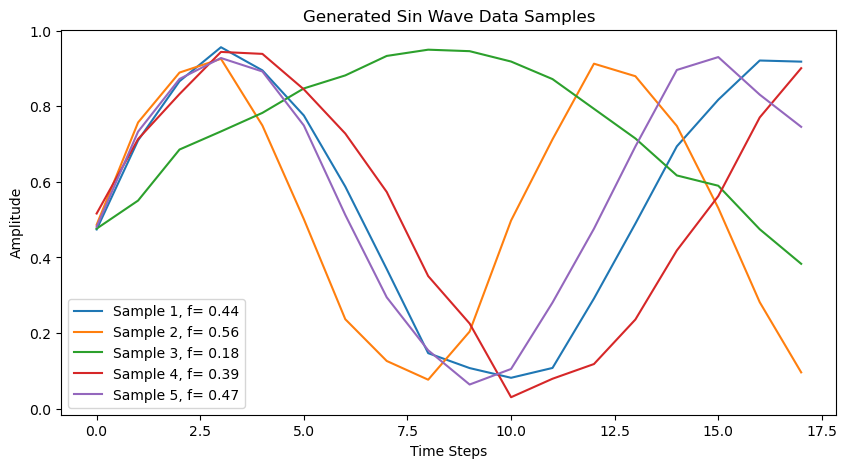

In [5]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X[i].flatten(), label=f"Sample {i+1}, f= {y_true[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [6]:
# train test split
percentage = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=1 - percentage, random_state=42
)

In [7]:
hparams = {
    "n_features": (n_features := 5),
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0),
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
}
sep = 7
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_1"
)
NAHEA_CNN.eval()

In [ ]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted, y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1}/{n_samples // batch_size}, Loss: {loss.item()}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]], requires_grad=True), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0082,  0.0274,  0.0629,  0.0321,  0.0737,  0.0271,  0.0098,  0.0398,
         0.0518,  0.0244,  0.0615,  0.0467,  0.0268,  0.0528,  0.0268,  0.0062,
         0.0223,  0.0642,  0.0615,  0.0197,  0.0532,  0.0378,  0.0665,  0.0710,
         0.0403,  0.0303,  0.0488,  0.0354,  0.0429, -0.0035,  0.0412,  0.0410],
       dt

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.23223505109797593


In [ ]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss: {loss_test.item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()
